<center>
<img src="../../img/ml_theme.png">
# Майнор "Интеллектуальный анализ данных" 
# Курс "Введение в анализ данных"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель ФКН НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="http://www.microsoft.com/en-us/openness/default.aspx#Ms-RL">Ms-RL</a>. Можно использовать в любых целях, но с обязательным упоминанием автора курса и аффилиации.

# Семинары 5 и 6. Линейные модели в машинном обучении

## Практика. Логистическая регрессия в соревновании Kaggle Forest Cover Type Prediction

[Соревнование](https://www.kaggle.com/c/forest-cover-type-prediction). 
Задача учебная. Предлагается предсказывать тип лесного покрытия на участках 30х30 метров Национального заповедника Рузвельта в Колорадо.

Признаки (подробней на [странице](https://www.kaggle.com/c/forest-cover-type-prediction/data) соревнования):

- Elevation (высота) - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope (наклон) - Slope in degrees
- Horizontal_Distance_To_Hydrology (горизонтальное расстояние до воды) - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology (вертикальное расстояние до воды) - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways (горизонтальное расстояние до дорог) - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice 
- Horizontal_Distance_To_Fire_Points (горизонтальное расстояние до центров воспламенения) - Horz Dist to nearest wildfire ignition points 
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (тип почвы) - (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

**Подключаем библиотеки и загружаем данные.**

In [30]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold, cross_val_score
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [31]:
train = pd.read_csv('../../data/forest_train.csv')
test = pd.read_csv('../../data/forest_test.csv')

In [32]:
train.head(1).T

,0
Id,1
Elevation,2596
Aspect,51
Slope,3
Horizontal_Distance_To_Hydrology,258
Vertical_Distance_To_Hydrology,0
Horizontal_Distance_To_Roadways,510
Hillshade_9am,221
Hillshade_Noon,232
Hillshade_3pm,148


In [33]:
def write_to_submission_file(predicted_labels, out_file,
                             target='Cover_Type', index_label="Id", init_index=15121):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(init_index, 
                                                  predicted_labels.shape[0] + init_index),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

# Исследование и создание признаков

**Смотрим на распределения признаков**

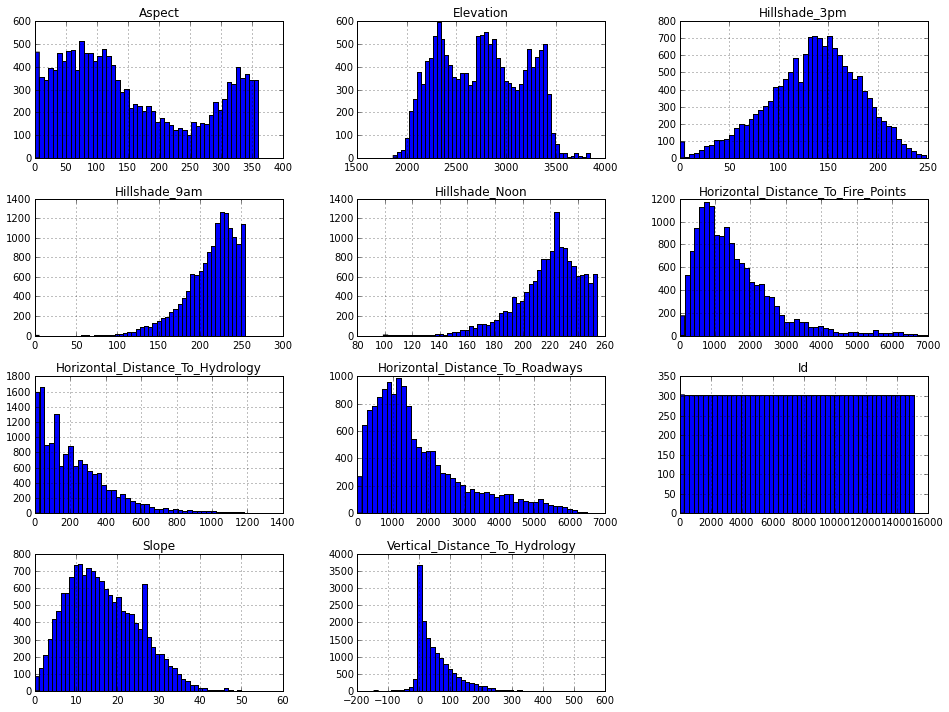

In [5]:
train.ix[:,:11].hist(figsize=(16,12),bins=50)
plt.show()

In [6]:
train['Hillshade_9am_transformed'] = np.log(train['Hillshade_9am'].max() + 1 - train['Hillshade_9am'])
test['Hillshade_9am_transformed'] = np.log(train['Hillshade_9am'].max() + 1 - test['Hillshade_9am'])

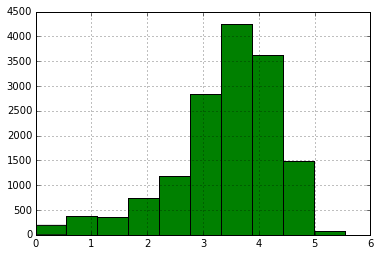

In [7]:
train['Hillshade_9am_transformed'].hist(color='green')

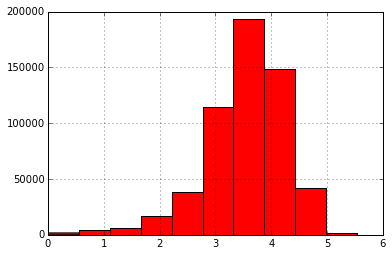

In [8]:
test['Hillshade_9am_transformed'].hist(color='red')

In [9]:
train['Horiz_dist_to_fire_transformed'] = np.log(1 + train['Horizontal_Distance_To_Fire_Points'])
test['Horiz_dist_to_fire_transformed'] = np.log(1 + test['Horizontal_Distance_To_Fire_Points'])

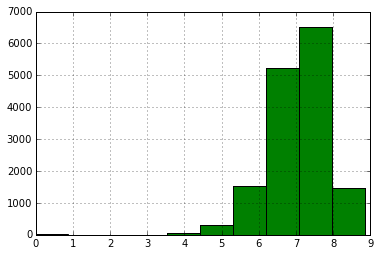

In [10]:
train['Horiz_dist_to_fire_transformed'].hist(color='green')

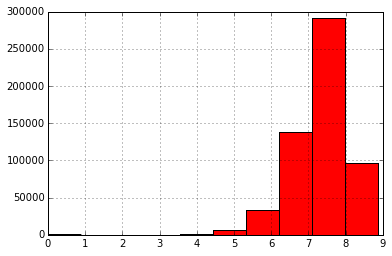

In [11]:
test['Horiz_dist_to_fire_transformed'].hist(color='red')

In [12]:
train['Horiz_dist_to_hydro_transformed'] = np.log(1 + train['Horizontal_Distance_To_Hydrology'])
test['Horiz_dist_to_hydro_transformed'] = np.log(1 + test['Horizontal_Distance_To_Hydrology'])

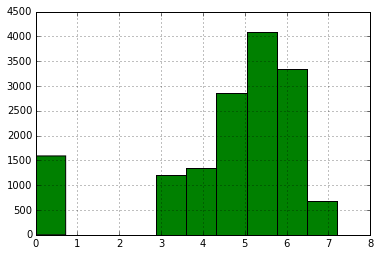

In [13]:
train['Horiz_dist_to_hydro_transformed'].hist(color='green')

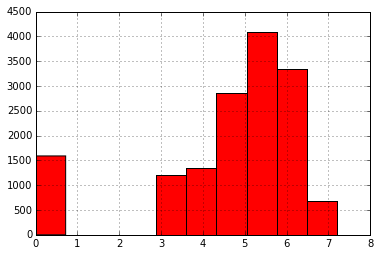

In [14]:
train['Horiz_dist_to_hydro_transformed'].hist(color='red')

In [15]:
train['Horiz_dist_to_roads_transformed'] = np.log(1 + train['Horizontal_Distance_To_Roadways'])
test['Horiz_dist_to_roads_transformed'] = np.log(1 + test['Horizontal_Distance_To_Roadways'])

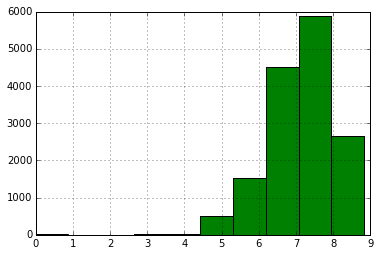

In [16]:
train['Horiz_dist_to_roads_transformed'].hist(color='green')

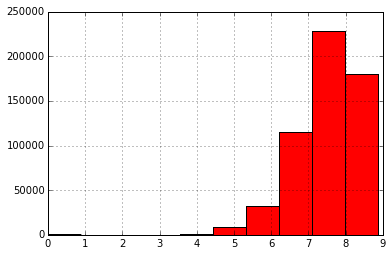

In [17]:
test['Horiz_dist_to_roads_transformed'].hist(color='red')

При подобных преобразованиях надо быть аккуратным:

- Преобразование должно быть одинаковым для обучающей и тестовой выборки
- Преобразование должно быть применимо к тестовой выборке

In [18]:
train['Vert_dist_to_hydro_transformed'] = np.log(-train['Vertical_Distance_To_Hydrology'].min() 
                                                 + 1 + train['Vertical_Distance_To_Hydrology'])
test['Vert_dist_to_hydro_transformed'] = np.log(-min(train['Vertical_Distance_To_Hydrology'].min(),
                                                     test['Vertical_Distance_To_Hydrology'].min())
                                                 + 1 + test['Vertical_Distance_To_Hydrology'])

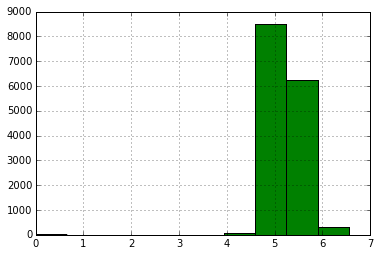

In [19]:
train['Vert_dist_to_hydro_transformed'].hist(color='green')

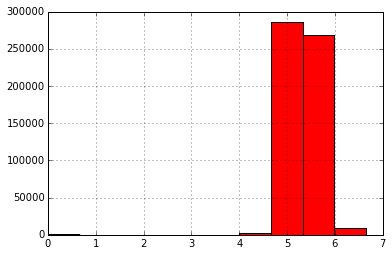

In [20]:
test['Vert_dist_to_hydro_transformed'].hist(color='red')

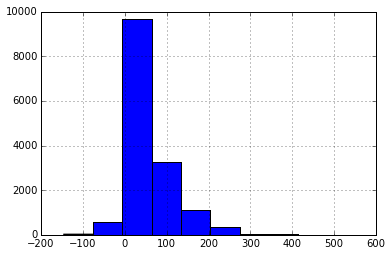

In [34]:
train['Vertical_Distance_To_Hydrology'].hist()

**Видим, что Vertical_Distance_To_Hydrology иногда бывает отрицательной, возможно, тем самым выделяется некоторый новый класс**

In [21]:
train['Under_water'] = train.Vertical_Distance_To_Hydrology < 0
test['Under_water'] = test.Vertical_Distance_To_Hydrology < 0

**Дальше пробуем строить графики зависимости некоторых признаков друг от друга**

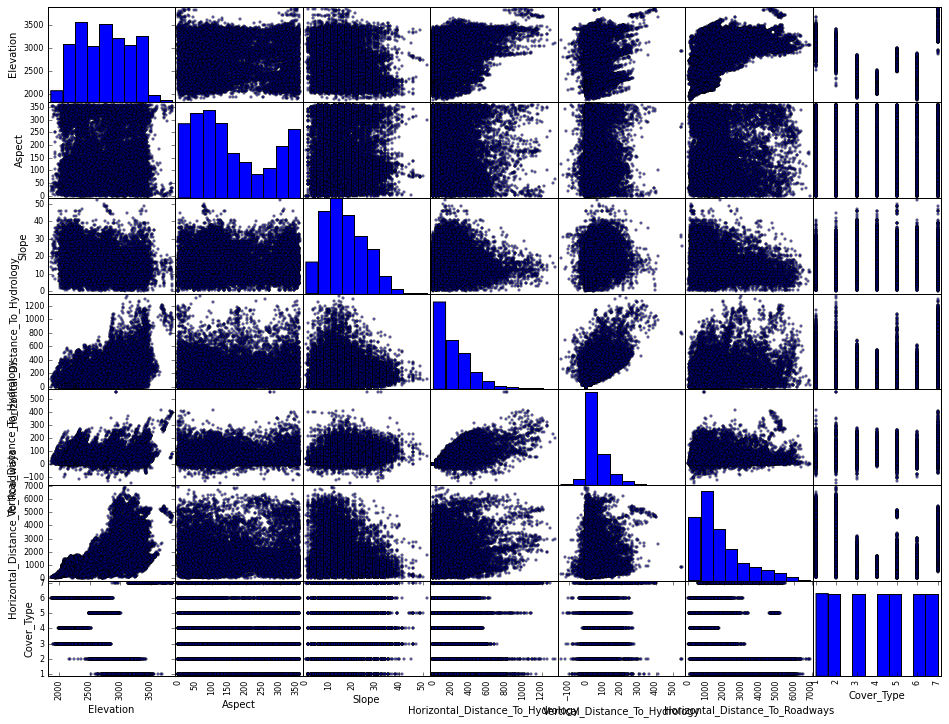

In [22]:
pd.scatter_matrix(train[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                   'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Cover_Type']], figsize=(16,12))
plt.show()

**Посмотрим на Elevation и Vertical_Distance_to_Hidrology**

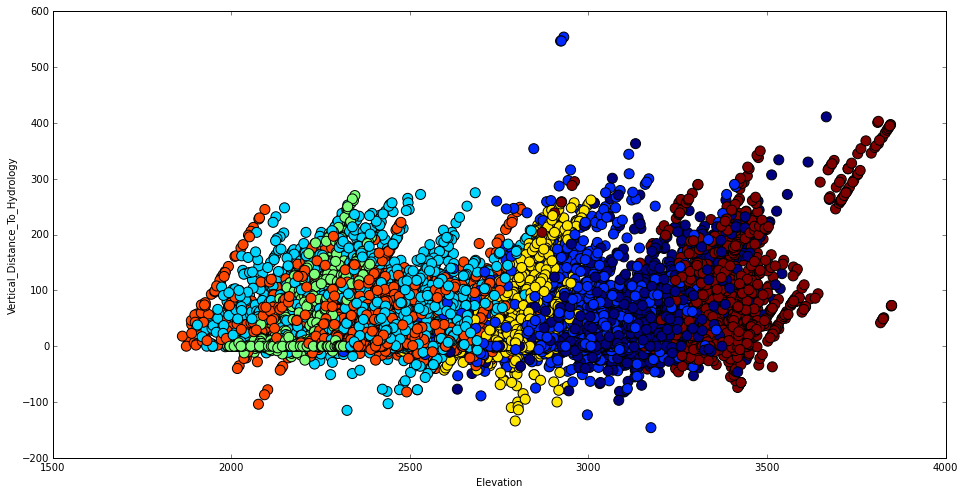

In [23]:
def plotc(c1,c2):

    fig = plt.figure(figsize=(16,8))
    sel = np.array(list(train.Cover_Type.values))

    plt.scatter(c1, c2, c=sel, s=100)
    plt.xlabel(c1.name)
    plt.ylabel(c2.name)
    
plotc(train.Elevation, train.Vertical_Distance_To_Hydrology)

**А теперь еще лучше график**

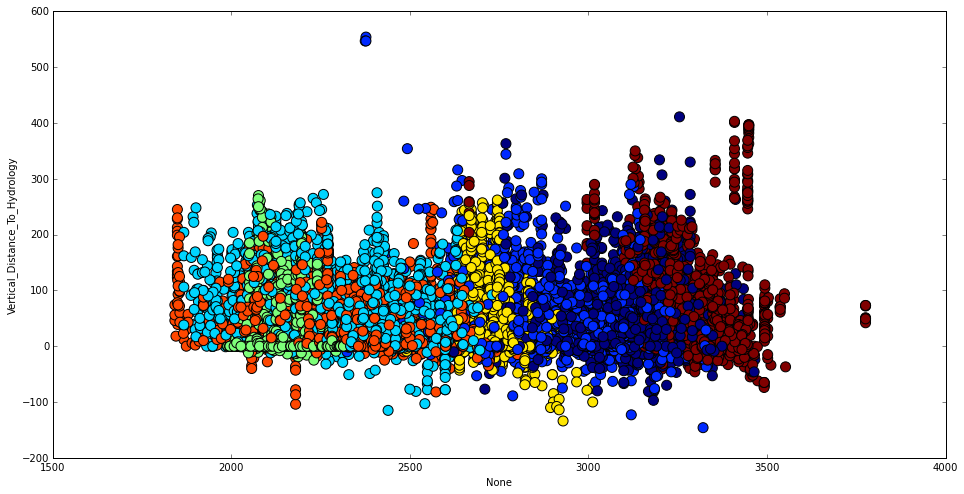

In [24]:
plotc(train.Elevation - train.Vertical_Distance_To_Hydrology, train.Vertical_Distance_To_Hydrology)

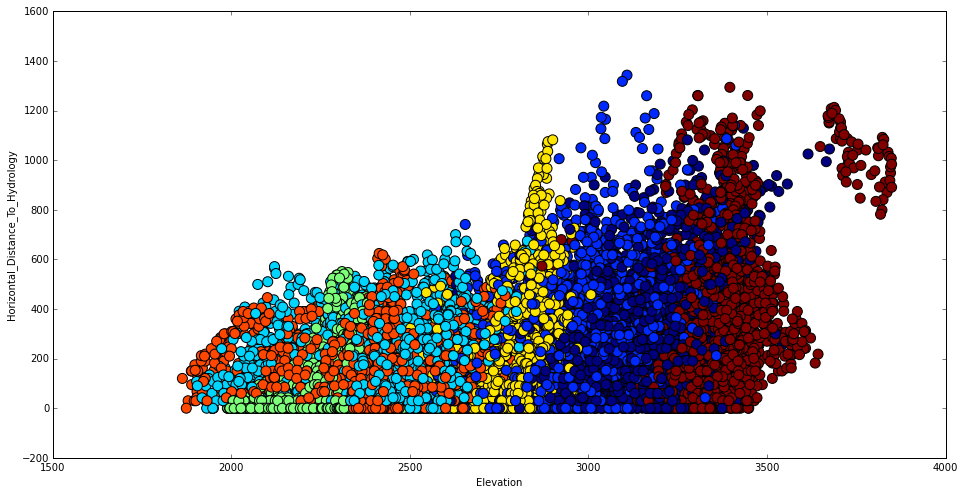

In [25]:
plotc(train.Elevation, train.Horizontal_Distance_To_Hydrology)

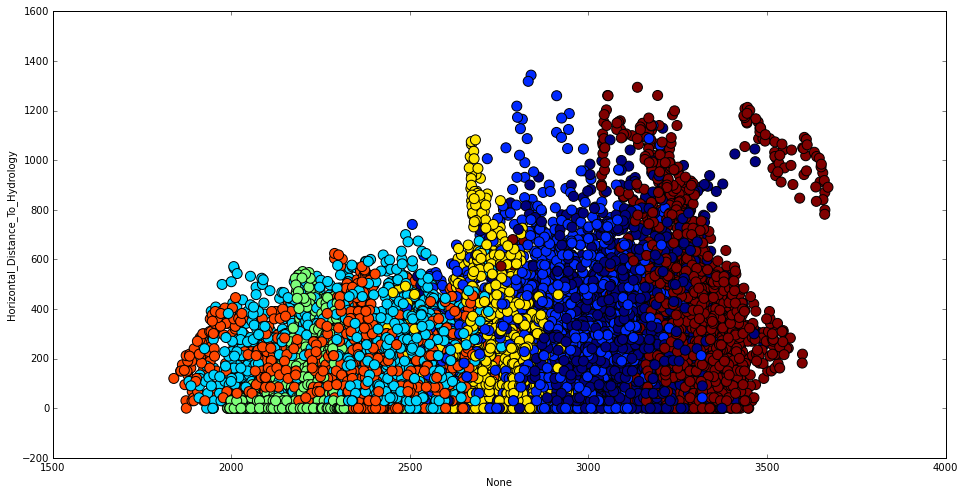

In [26]:
plotc(train.Elevation - train.Horizontal_Distance_To_Hydrology*0.2, train.Horizontal_Distance_To_Hydrology)

In [27]:
train['EVDtH'] = train.Elevation - train.Vertical_Distance_To_Hydrology
test['EVDtH'] = test.Elevation - test.Vertical_Distance_To_Hydrology

train['EHDtH'] = train.Elevation - train.Horizontal_Distance_To_Hydrology*0.2
test['EHDtH'] = test.Elevation - test.Horizontal_Distance_To_Hydrology*0.2

**Дальше можем создать еще множество дополнительных признаков.**

In [28]:
train['Hydro_Fire_1'] = train['Horizontal_Distance_To_Hydrology'] + train['Horizontal_Distance_To_Fire_Points']
test['Hydro_Fire_1'] = test['Horizontal_Distance_To_Hydrology'] + test['Horizontal_Distance_To_Fire_Points']

train['Hydro_Fire_2'] = abs(train['Horizontal_Distance_To_Hydrology'] - train['Horizontal_Distance_To_Fire_Points'])
test['Hydro_Fire_2'] = abs(test['Horizontal_Distance_To_Hydrology'] - test['Horizontal_Distance_To_Fire_Points'])

train['Hydro_Road_1'] = abs(train['Horizontal_Distance_To_Hydrology'] + train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_1'] = abs(test['Horizontal_Distance_To_Hydrology'] + test['Horizontal_Distance_To_Roadways'])

train['Hydro_Road_2'] = abs(train['Horizontal_Distance_To_Hydrology'] - train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_2'] = abs(test['Horizontal_Distance_To_Hydrology'] - test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_1'] = abs(train['Horizontal_Distance_To_Fire_Points'] + train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_1'] = abs(test['Horizontal_Distance_To_Fire_Points'] + test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_2'] = abs(train['Horizontal_Distance_To_Fire_Points'] - train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_2'] = abs(test['Horizontal_Distance_To_Fire_Points'] - test['Horizontal_Distance_To_Roadways'])

## Задание 

**1. Создайте признак 'Distanse_to_Hydrolody' как евклидово расстояние до воды.**

In [ ]:
train['Distanse_to_Hydrolody'] = # Ваш код здесь
test['Distanse_to_Hydrolody'] = # Ваш код здесь

**2. Исключите признак 'Id', составьте обучающую и тестовую выборки, а также вектор ответов y (используя столбец 'Cover_Type'). При необходимости посмотрите документацию к методу drop pandas.DataFrame - обратите внимание на аргументы axis и inplace.**

In [ ]:
y = # Ваш код здесь
X_train = # Ваш код здесь
X_test = # Ваш код здесь

**3a. Проведите кросс-валидацию для логистической регрессии без настройки параметров и без шкалирования признаков.
Используйте разбиение на подвыборки с помощью StratifiedKFold. При необходимости посмотрите документацию для методов StratifiedKFold и cross_val_score.**

In [ ]:
logit = LogisticRegression()

In [ ]:
np.mean(cross_val_score # Ваш код здесь

**3b. Обучите модель на всей выборке, сделайте прогноз для тестовой выборки, сформируйте файл посылки и отправьте его на Kaggle. Какой получилась доля правильных ответов на приватной части тестовой выборки?**

In [ ]:
logit.fit(X_train, y)

In [ ]:
first_logit_prediction = # Ваш код здесь

In [ ]:
write_to_submission_file(first_logit_prediction, '../../output/first_logit.csv')

**4a. Проведите кросс-валидацию для логистической регрессии без настройки параметров и со шкалированием признаков.
Используйте StandardScaler из sklearn.preprocessing.**

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_train_scaled = # Ваш код здесь
X_test_scaled = # Ваш код здесь

In [ ]:
logit = LogisticRegression()

In [ ]:
np.mean(cross_val_score # Ваш код здесь

**4b. Обучите модель на всей выборке, сделайте прогноз для тестовой выборки, сформируйте файл посылки и отправьте его на Kaggle. Какой получилась доля правильных ответов на приватной части тестовой выборки?**

In [ ]:
logit.fit(X_train_scaled, y)

In [ ]:
second_logit_prediction = # Ваш код здесь

In [ ]:
write_to_submission_file(second_logit_prediction, '../../output/second_logit.csv')

**5a. Проведите кросс-валидацию для логистической регрессии с настройкой параметров и со шкалированием признаков.
Используйте метод поиска параметров перебором GridSearchCV из sklearn.grid_search. Ищите значение параметра C сначала в широком диапазоне (например, $10^3 - 10^6$), а потом в более узком. Это может занять по 2 минуты на каждый перебор.**

In [ ]:
from sklearn.grid_search import GridSearchCV

In [ ]:
c_values = {'C': np.logspace(3, 7, 5)}
grid_search_logit = GridSearchCV  # Ваш код здесь
grid_search_logit.fit(X_train_scaled, y)

In [ ]:
grid_search_logit.best_params_, grid_search_logit.best_score_

In [ ]:
c_values = {'C': np.linspace(9000, 10100, 5)}
grid_search_logit = GridSearchCV  # Ваш код здесь
grid_search_logit.fit(X_train_scaled, y)

In [ ]:
grid_search_logit.best_params_, grid_search_logit.best_score_

**5b. Обучите лучшую модель, найденную методом GridSearchCV (best\_estimator\_), на всей выборке, сделайте прогноз для тестовой выборки, сформируйте файл посылки и отправьте его на Kaggle. Какой получилась доля правильных ответов на приватной части тестовой выборки?**

In [ ]:
grid_search_logit # Ваш код здесь

In [ ]:
third_logit_prediction = # Ваш код здесь

In [ ]:
write_to_submission_file(third_logit_prediction, '../../output/third_logit.csv')